In [1]:
import re
import os
import time
import datetime
import calendar
import tqdm
import cftime
import dask

#from ctsm_py import utils
from netCDF4 import num2date
from glob import glob
from os.path import join

import numpy as np
import pandas as pd
import xarray as xr

# some resources for plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

### Functions

In [2]:

def to_sparse(data, vegtype, jxy, ixy, shape):
    """
    Takes an input numpy array and converts it to a sparse array.

    Parameters
    ----------
    data: numpy.ndarray
        1D or 2D Data stored in compressed form.
    vegtype: numpy.ndarray

    jxy: numpy.ndarray
        Latitude index
    ixy: numpy.ndarray
        Longitude index
    shape: tuple
        Shape provided as sizes of (vegtype, jxy, ixy) in uncompressed
        form.

    Returns
    -------
    sparse.COO
        Sparse nD array
    """
    import sparse

    # This constructs a list of coordinate locations at which data exists
    # it works for arbitrary number of dimensions but assumes that the last dimension
    # is the "stacked" dimension i.e. "pft"
    if data.ndim == 1:
        coords = np.stack([vegtype, jxy - 1, ixy - 1], axis=0)
    elif data.ndim == 2:
        # generate some repeated time indexes
        # [0 0 0 ... 1 1 1... ]
        itime = np.repeat(np.arange(data.shape[0]), data.shape[1])
        # expand vegtype and friends for all time instants
        # by sequentially concatenating each array for each time instants
        tostack = [np.concatenate([array] * data.shape[0]) for array in [vegtype, jxy - 1, ixy - 1]]
        coords = np.stack([itime] + tostack, axis=0)
    else:
        raise NotImplementedError

    return sparse.COO(
        coords=coords,
        data=data.ravel(),
        shape=data.shape[:-1] + shape,
        fill_value=np.nan,
    )



In [3]:
def convert_pft_variables_to_sparse(dataset, pftnames):
    """
    Convert 2D PFT variables in dataset to 4D sparse arrays.

    Parameters
    ----------
    dataset: xarray.Dataset
        Dataset with DataArrays that have a `pft` dimension.

    Returns
    -------
    xarray.Dataset
        Dataset whose "PFT" arrays are now sparse arrays
        with `pft` dimension expanded out to (type, lat, lon)
    """

    import sparse
    import xarray as xr

    # extract PFT variables
    pfts = xr.Dataset({k: v for k, v in dataset.items() if "pft" in v.dims})

    # extract coordinate index locations
    ixy = dataset.pfts1d_ixy.astype(int)
    jxy = dataset.pfts1d_jxy.astype(int)
    vegtype = dataset.pfts1d_itype_veg.astype(int)
    npft = len(pftnames.data)

    # expected shape of sparse arrays to pass to `to_sparse` (excludes time)
    output_sizes = {
        "vegtype": npft,
        "lat": dataset.sizes["lat"],
        "lon": dataset.sizes["lon"],
    }

    result = xr.Dataset()
    # we loop over variables so we can specify the appropriate dtype
    for var in pfts:
        result[var] = xr.apply_ufunc(
            to_sparse,
            pfts[var],
            vegtype,
            jxy,
            ixy,
            kwargs=dict(shape=tuple(output_sizes.values())),
            input_core_dims=[["pft"]] * 4,
            output_core_dims=[["vegtype", "lat", "lon"]],
            dask="parallelized",
            dask_gufunc_kwargs=dict(
                meta=sparse.COO(np.array([], dtype=pfts[var].dtype)),
                output_sizes=output_sizes,
            ),
            keep_attrs=True,
        )

    # copy over coordinate variables lat, lon
    result = result.update(dataset[["lat", "lon"]])
    result["vegtype"] = pftnames.data
    # save the dataset attributes
    result.attrs = dataset.attrs
    return result

In [4]:

def survivability_plot(sparse_data,var,casename,frac_coverage_wt,outfile):
    if var == 'TLAI':
        cmap = plt.cm.viridis_r
        cmap.set_under(color='deeppink')
        levels = [0.1, 1, 2, 3, 4, 5, 6,7]
    
    else:
        cmap = plt.cm.viridis_r
        cmap.set_under(color='white')
        levels = [0.01, .1, .2, .3, .4, .5, .6, .7]
    
    mask = xr.where(sparse_data['pfts1d_wtgcell'] < frac_coverage_wt,np.nan,1)
    fg = (mask*sparse_data[var].isel(vegtype=slice(1, 16))).sel(lat=slice(-65,85)).plot(
        x = "lon", y="lat", col = "vegtype", 
        col_wrap=3, cmap = cmap, levels=levels,
        cbar_kwargs={#"orientation": "vertical", "shrink": 0.8, 
                     #"aspect": 40, "pad": 0.01
        },
        transform = ccrs.PlateCarree(),
        subplot_kws={"projection": ccrs.PlateCarree()},
        add_colorbar=False
    )
    
    # Make some custom titles and info for each plot
    titles,mean,alive,area = [],[],[],[]
    for i in range(1,16):
        titles.append(str(sparse_data.vegtype[i].data)[2:38])
        if var == 'TLAI':
            mean.append('mean = '+str(np.round((mask*sparse_data[var]).isel(vegtype=i).mean().values,1)))
            dead = ((mask*sparse_data[var]).isel(vegtype=i)<0.1).sum()
            live = ((mask*sparse_data[var]).isel(vegtype=i)>0.1).sum()
            livefrac = str(np.round((live/(live+dead)).values,2))
            alive.append('live frac = '+livefrac)
        else: 
            tempArea = ((mask*sparse_data[var]).isel(vegtype=i) * ds_in.area * ds_in.landfrac).sum()*1e-6
            area.append(str(np.round(tempArea.values,2))+" (1e6 km2)")
    
    if var == 'TLAI':
        for ax, mean in zip(fg.axs.flat, mean):
            ax.text(-30,-45,mean,fontsize=8)
            
        for ax, alive in zip(fg.axs.flat, alive):
            ax.text(-45,-60,alive,fontsize=8)
    else:
        for ax, area in zip(fg.axs.flat, area):
            ax.text(-45,-60,area,fontsize=8)
        
    for ax, title in zip(fg.axs.flat, titles):
        ax.set_title(title,fontsize=10)#,loc='left',backgroundcolor = 'white')
    for ax in fg.axs.flat:  # loop through the map axes
        ax.coastlines()
    
    #fg.fig.title('test title')
    
    fg.fig.set_layout_engine("compressed")
    fg.add_colorbar(pad=0.02, shrink=0.9, aspect=40)
    fg.cbar.ax.tick_params(labelsize=12)
    if var == 'TLAI':
        fg.cbar.set_label(label=("max LAI "+casename), size=15, weight='bold')
    else:
        fg.cbar.set_label(label=("grid_weights "+casename), size=15, weight='bold')
        
    plt.savefig(outfile)
    plt.show()

### Set up

In [5]:
### setup
year = 1850
in_dir = '/glade/derecho/scratch/wwieder/archive/ctsm53065_54surfdata_PPEcal115_115_HIST/lnd/hist/'
#in_dir = '/glade/derecho/scratch/linnia/ctsm53065_cal094_cold_HIST/run/'

pft_constants = xr.open_dataset('/glade/campaign/cesm/cesmdata/cseg/inputdata/lnd/clm2/paramdata/ctsm60_params.c241017.nc')
pftnames = pft_constants.pftname

In [6]:
### Load data
filelist = np.sort(glob(os.path.join(in_dir, f'*h1a*{year}*')))
ds_in = xr.open_mfdataset(filelist, decode_times=True).max('time')
sparse_data = convert_pft_variables_to_sparse(ds_in, pftnames).load()

### Plot

In [7]:
var='TLAI'
frac_coverage_wt = 0.05
casename = 'PPEcal115_#115'
outfile = '../figs/survivability_'+casename+'_'+str(year)+'.png'

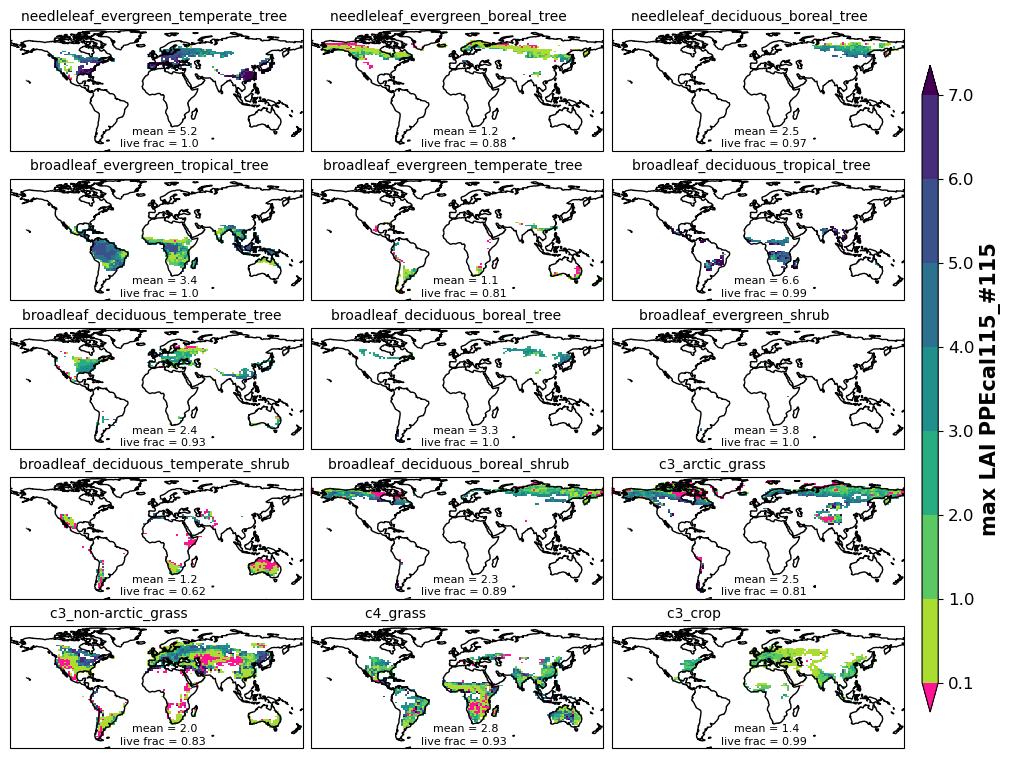

In [8]:
survivability_plot(sparse_data,var,casename,frac_coverage_wt,outfile)